# Exploring PQC Circuits, Optimizers, etc for QAOA with TFQ

This is an exploration of MaxCut mapping to QAOA circuits, different optimizers, losses, etc. provided in TFQ/TF for QAOA parameter optimization

## Import Necessary Libraries

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

# visualization tools
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
#supress warning for matplotlib
import warnings
warnings.filterwarnings("ignore")
import networkx as nx

## QAOA Ansatz
The QAOA alternates between the implementation of a cost hamiltonian ($\hat{H}_C$) and a mixer hamiltonian ($\hat{H}_M$) for a depth p times. This results in an overall unitary operator defined as:

$$\hat{U}(\vec{\gamma},\vec{\beta})= \prod_{p=1}^{n}e^{-i\gamma_{p}\hat{H}_M}e^{-i\beta_{p} \hat{H}_C}$$
Here, $\hat{H}_C$ represents the cost Hamiltonian which, for the MaxCut problem within the class of Ising models, is:
$$\hat{H}_C=\sum_{<i,j>}(I_{2}-\sigma_{i}^{z}\sigma_{j}^{z})$$

    
The mixing Hamiltonian, $\hat{H}_M$, is defined as:
$$\hat{H}_M=\sum_{k=1}^{N}\sigma_{k}^{x}$$

Since MaxCut graph can vary in __nodes__ (N), __connectivity__ (can be d-regular, where $d\in [0,N-1],\mathbb{Z^{+}}$), and __edge weight distribution__ (for unweighted, $w_{i}=1\; \forall \; edges$), mapping one versus another onto a QAOA can look very different. Here's how the circuit structure changes with different variations of MaxCut graphs:

In [2]:
# Define a MaxCut graph to QAOA circuit mapping
def maxcut_qaoa_circuit(graph, depth_tot):
    # Map nodes to qubits 1:1
    qubits = cirq.GridQubit.rect(1, len(graph.nodes))
    # Create vars for circuit and total parameters
    hadamard_circuit = cirq.Circuit()
    qaoa_circuit = cirq.Circuit()
    #hadamard_circuit = cirq.Circuit()
    qaoa_params = []
    
    
    # Apply Hadamard Transform for initial equal superposition
    for q in qubits:
        hadamard_circuit += cirq.H(q)
    qaoa_circuit.append(hadamard_circuit)
    
    # Create parameter set
    for depth in range(depth_tot):
        qaoa_params.append(sympy.Symbol("gamma_{}".format(depth)))
    
    # Create {H_C, H_M} alternating depth_tot times 
        for edge in graph.edges():
            
            qaoa_circuit += cirq.ZZ(qubits[edge[0]], qubits[edge[1]])**qaoa_params[-1]
        qaoa_params.append(sympy.Symbol("beta_{}".format(depth)))
        
        for node in graph.nodes():
            qaoa_circuit += cirq.X(qubits[node])**qaoa_params[-1]
            
    # Define the cost as a Cirq PauliSum
    cost_op = None
    for edge in graph.edges():
        if cost_op is None:
            cost_op = cirq.Z(qubits[edge[0]])*cirq.Z(qubits[edge[1]])
        else:
            cost_op += cirq.Z(qubits[edge[0]])*cirq.Z(qubits[edge[1]])
    
    return SVGCircuit(qaoa_circuit)

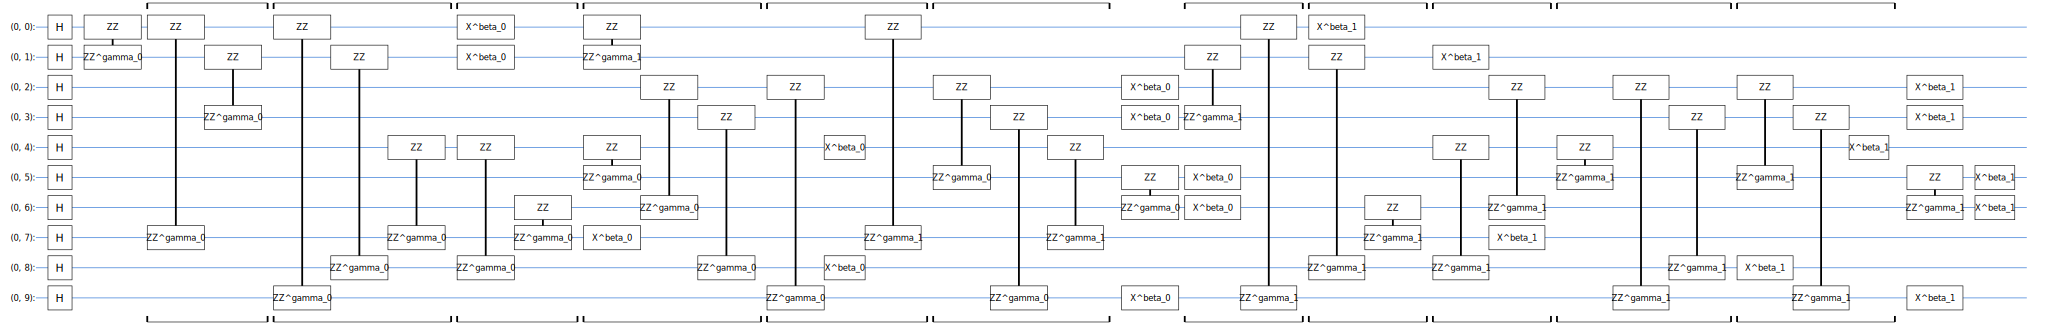

In [34]:
graph_a = nx.random_regular_graph(n=10,d=3)
maxcut_qaoa_circuit(graph_a, 2)

## Alternate Method for $p>1$
1. When we define the model and training data for the QAOA circuit, unlike regular ML models there are no training inputs or corresponding labels. We need to use the initial superposition ($H^{\otimes N-1}|0>^{\otimes N-1}$) as our input after converting it to a tensor for TFQ compatibility. 
2. I'm still working through how to get the initial maxcut_qaoa_graph definition to work with the TFQ framework, so for now I'm temporarily building up each part of the circuit needed, allowing me to easily pass them into the TFQ framework/ model:

In [9]:
# Define initial superposition, H_(N-1)
cirq_qubits = cirq.GridQubit.rect(1, 10)

hadamard_circuit = cirq.Circuit()
for node in graph_a.nodes():
    qubit = cirq_qubits[node]
    hadamard_circuit.append(cirq.H(qubit))

In [10]:
# Define params
qaoa_parameters = sympy.symbols('gamma0 beta0 gamma1 beta1')

In [11]:
# define the the mixing and the cost Hamiltonian, H_M and H_P

mixing_ham_1 = 0
mixing_ham_2 = 0
cost_ham_1 = graph_a.number_of_edges()/2
cost_ham_2 = graph_a.number_of_edges()/2
for node in graph_a.nodes():
    qubit = cirq_qubits[node]
    mixing_ham_1 += cirq.PauliString(cirq.X(qubit))

for edge in graph_a.edges():
    qubit1 = cirq_qubits[edge[0]]
    qubit2 = cirq_qubits[edge[1]]
    cost_ham_1 += cirq.PauliString(1/2*(cirq.Z(qubit1)*cirq.Z(qubit2)))
 
for node in graph_a.nodes():
    qubit = cirq_qubits[node]
    mixing_ham_2 += cirq.PauliString(cirq.X(qubit))

for edge in graph_a.edges():
    qubit1 = cirq_qubits[edge[0]]
    qubit2 = cirq_qubits[edge[1]]
    cost_ham_2 += cirq.PauliString(1/2*(cirq.Z(qubit1)*cirq.Z(qubit2)))

# generate the qaoa circuit
qaoa_circuit = tfq.util.exponential(operators = [cost_ham_1, mixing_ham_1, cost_ham_2, mixing_ham_2], 
                                    coefficients = qaoa_parameters)

In [12]:
# define the model and training data
model_circuit, model_readout = qaoa_circuit, cost_ham_2
input_ = [hadamard_circuit]
input_ = tfq.convert_to_tensor(input_)
optimum = [0]

Shown here there are 4, or 2p, parameters to optimize here which agrees with our circuit depth of 2:

In [13]:
# Build the Keras model.
optimum=np.array(optimum)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string),  # Input layer for the hadamard circuit
    tfq.layers.PQC(model_circuit, model_readout)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc (PQC)                    (None, 1)                 4         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


We now compile the model, choosing the __loss, optimizer, and metric__ and as mentioned earlier the TFQ framework allows us to use GD, SGD, Adam, etc. as optimizers. Here we use the Adam optimizer:

In [14]:
model.compile(loss=tf.keras.losses.mean_absolute_error,
              optimizer=tf.keras.optimizers.Adam())

Let's also create an early stopping mechanism to make the time the model needs to train more efficient

In [15]:
# Create early stopping mechanism
callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=0.005, patience=0, verbose=1)

Now we fit/train the model with our Hadamard circuit as input and a desired loss of 0:

In [16]:
# Train the model
history = model.fit(input_,optimum,epochs=600, callbacks=[callback], verbose=1)

Train on 1 samples
Epoch 1/600
1/1 [==============================] - 1s 1s/sample - loss: 8.2207
Epoch 2/600
1/1 [==============================] - 0s 13ms/sample - loss: 8.2102
Epoch 3/600
1/1 [==============================] - 0s 15ms/sample - loss: 8.1997
Epoch 4/600
1/1 [==============================] - 0s 14ms/sample - loss: 8.1891
Epoch 5/600
1/1 [==============================] - 0s 15ms/sample - loss: 8.1786
Epoch 6/600
1/1 [==============================] - 0s 15ms/sample - loss: 8.1681
Epoch 7/600
1/1 [==============================] - 0s 15ms/sample - loss: 8.1575
Epoch 8/600
1/1 [==============================] - 0s 14ms/sample - loss: 8.1470
Epoch 9/600
1/1 [==============================] - 0s 14ms/sample - loss: 8.1365
Epoch 10/600
1/1 [==============================] - 0s 10ms/sample - loss: 8.1260
Epoch 11/600
1/1 [==============================] - 0s 12ms/sample - loss: 8.1154
Epoch 12/600
1/1 [==============================] - 0s 12ms/sample - loss: 8.1049
Epoch 13

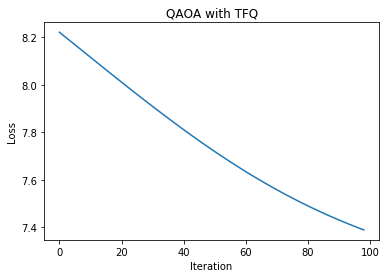

In [17]:
plt.plot(history.history['loss'])
plt.title("QAOA with TFQ")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [22]:
# Let's look at the optimal paramaters from training
params = model.trainable_variables

<tf.Variable 'parameters:0' shape=(4,) dtype=float32, numpy=array([0.48674062, 3.815017  , 4.2800107 , 3.4325886 ], dtype=float32)>


Once trained, we see the optimal parameters, which are:
$$\vec\alpha=\displaystyle \left[\begin{matrix}0.48674062\\4.2800107\end{matrix}\right], \; \vec\beta=\displaystyle \left[\begin{matrix}3.815017\\3.4325886\end{matrix}\right] $$
So let's now sample from the final state for many repeitions, resulting in a bitstring which is the measurement of each qubit for x reps

In [23]:
# Sample from the final state 1000 times
params = model.trainable_variables
add = tfq.layers.AddCircuit()
output_circuit = add(input_, append =qaoa_circuit )

sample_layer = tfq.layers.Sample()
output = sample_layer(output_circuit,  symbol_names=qaoa_parameters, symbol_values = params,repetitions=1000)

Instructions for updating:
reduction_indices is deprecated, use axis instead


In [24]:
# Output has measurement of all 10 qubits, 1000 times using optimal beta, gamma params
# Here's the first 10 reps and the outputs 
for i, element in enumerate(output.values[:10]):
    print(f'\nrep {i} qubit measurements:\n')
    for j, bit in enumerate(element):
        print(f'qubit {j} measurment: {bit}')


rep 0 qubit measurements:

qubit 0 measurment: 0
qubit 1 measurment: 1
qubit 2 measurment: 1
qubit 3 measurment: 0
qubit 4 measurment: 1
qubit 5 measurment: 0
qubit 6 measurment: 1
qubit 7 measurment: 0
qubit 8 measurment: 1
qubit 9 measurment: 1

rep 1 qubit measurements:

qubit 0 measurment: 1
qubit 1 measurment: 1
qubit 2 measurment: 1
qubit 3 measurment: 0
qubit 4 measurment: 0
qubit 5 measurment: 0
qubit 6 measurment: 1
qubit 7 measurment: 0
qubit 8 measurment: 1
qubit 9 measurment: 0

rep 2 qubit measurements:

qubit 0 measurment: 0
qubit 1 measurment: 1
qubit 2 measurment: 1
qubit 3 measurment: 0
qubit 4 measurment: 1
qubit 5 measurment: 1
qubit 6 measurment: 0
qubit 7 measurment: 1
qubit 8 measurment: 0
qubit 9 measurment: 0

rep 3 qubit measurements:

qubit 0 measurment: 0
qubit 1 measurment: 0
qubit 2 measurment: 1
qubit 3 measurment: 1
qubit 4 measurment: 1
qubit 5 measurment: 1
qubit 6 measurment: 0
qubit 7 measurment: 0
qubit 8 measurment: 1
qubit 9 measurment: 0

rep 4 q

In [35]:
# Store the position of all the 1s in a list for the cut set
all_ones = []
for bitstr in output.values:
    temp_list = []
    for pos, bit in enumerate(bitstr):
        if bit==1:
            temp_list.append(pos)
    all_ones.append(temp_list)

all_ones[:50]

[[1, 2, 4, 6, 8, 9],
 [0, 1, 2, 6, 8],
 [1, 2, 4, 5, 7],
 [2, 3, 4, 5, 8],
 [0, 1, 2, 4, 9],
 [0, 1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6, 8],
 [0, 2, 3, 7, 8],
 [0, 1, 5, 6, 8, 9],
 [0, 2, 4, 9],
 [3, 4, 5, 6, 8],
 [0, 1, 2, 3, 6, 8],
 [1, 3, 5, 6, 8],
 [0, 5, 6, 7, 8, 9],
 [1, 3, 4, 6, 7, 8, 9],
 [0, 1, 3, 7, 8, 9],
 [0, 5, 9],
 [1, 2, 3, 5, 7, 9],
 [0, 2, 5, 7, 8],
 [2, 3, 4, 6, 7, 8],
 [2, 4, 5, 7, 9],
 [0, 1, 3, 5, 7],
 [0, 4, 5, 6, 7],
 [1, 2, 4, 5, 8, 9],
 [1, 2, 3, 4, 5],
 [0, 1, 2, 5],
 [0, 3, 4, 5, 6, 7],
 [0, 2, 3, 4, 9],
 [0, 1, 2, 3, 8],
 [6, 7, 8, 9],
 [2, 5, 8],
 [0, 1, 2, 3, 4],
 [3, 4, 5, 8, 9],
 [0, 2, 4, 6, 7],
 [1, 2, 5, 6, 7, 8],
 [0, 1, 3, 4, 6, 7, 8],
 [0, 1, 2, 4, 5, 6, 7, 9],
 [0, 2, 3, 5, 7, 8],
 [4, 6, 8, 9],
 [0, 1, 6, 7, 8],
 [0, 4, 7, 8, 9],
 [1, 4, 9],
 [1, 2, 3, 5, 9],
 [0, 1, 2, 4, 7, 8, 9],
 [0, 1, 2, 3, 5, 7, 8],
 [0, 2],
 [0, 1, 2, 5, 7, 8, 9],
 [1, 3, 4, 6, 7, 8],
 [0, 2, 5, 9],
 [7, 8, 9]]

In [36]:
# Generate a list with all possible subsets- combinatorial total
from itertools import combinations
sub_lists = []
for i in range(0, len(graph_a.nodes())+1):
  temp = [list(x) for x in combinations(graph_a.nodes(), i)]
  sub_lists.extend(temp)

sub_lists[:50]

[[],
 [0],
 [1],
 [4],
 [7],
 [2],
 [6],
 [3],
 [9],
 [8],
 [5],
 [0, 1],
 [0, 4],
 [0, 7],
 [0, 2],
 [0, 6],
 [0, 3],
 [0, 9],
 [0, 8],
 [0, 5],
 [1, 4],
 [1, 7],
 [1, 2],
 [1, 6],
 [1, 3],
 [1, 9],
 [1, 8],
 [1, 5],
 [4, 7],
 [4, 2],
 [4, 6],
 [4, 3],
 [4, 9],
 [4, 8],
 [4, 5],
 [7, 2],
 [7, 6],
 [7, 3],
 [7, 9],
 [7, 8],
 [7, 5],
 [2, 6],
 [2, 3],
 [2, 9],
 [2, 8],
 [2, 5],
 [6, 3],
 [6, 9],
 [6, 8],
 [6, 5]]

In [32]:
# Calculate the cut_size for all possible cuts
cut_size = []
for sub_list in sub_lists:
  cut_size.append(nx.algorithms.cuts.cut_size(graph_a,sub_list))


print("For all possible cuts (first 20):")


print(f'Cut sizes: {cut_size[:20]}\n')
print(f'Corresponding cut set: {sub_lists[:20]}')

# Calculate the cut_size for the cuts found with QAOA
cut_size_qaoa = []
for cut in cuts_qaoa:
  cut_size_qaoa.append(nx.algorithms.cuts.cut_size(graph_a,cut))

# preview the differences between QAOA and all cuts
print("\nFound with QAOA:")
print(f'Cut sizes (QAOA): {cut_size_qaoa[:20]}\n')
print(f'Corresponding QAOA found cut set: {cuts_qaoa[:20]}')

For all possible cuts (first 20):
Cut sizes: [0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 6, 4, 6, 4, 6, 6, 6, 6]

Corresponding cut set: [[], [4], [7], [2], [6], [5], [1], [8], [9], [3], [0], [4, 7], [4, 2], [4, 6], [4, 5], [4, 1], [4, 8], [4, 9], [4, 3], [4, 0]]

Found with QAOA:
Cut sizes (QAOA): [8, 9, 9, 11, 9, 7, 9, 7, 6, 10, 9, 10, 11, 8, 5, 6, 7, 8, 7, 8]

Corresponding QAOA found cut set: [[1, 2, 4, 6, 8, 9], [0, 1, 2, 6, 8], [1, 2, 4, 5, 7], [2, 3, 4, 5, 8], [0, 1, 2, 4, 9], [0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 8], [0, 2, 3, 7, 8], [0, 1, 5, 6, 8, 9], [0, 2, 4, 9], [3, 4, 5, 6, 8], [0, 1, 2, 3, 6, 8], [1, 3, 5, 6, 8], [0, 5, 6, 7, 8, 9], [1, 3, 4, 6, 7, 8, 9], [0, 1, 3, 7, 8, 9], [0, 5, 9], [1, 2, 3, 5, 7, 9], [0, 2, 5, 7, 8], [2, 3, 4, 6, 7, 8]]


In [33]:
# Finally, calculate the approximation ratio 
np.mean(cut_size_qaoa)/np.max(cut_size)

0.6262307692307693